ResNet50

In [4]:
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from PIL import Image
import os
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision

# -------------------------------
# 1. Load and Prepare Data
# -------------------------------
with open('updated_merge_json_150x250.pkl', 'rb') as f:
    data = pickle.load(f)

# Normalize class labels
class_counts = {'oa': 0, 'gout': 0, 'normal': 0, 'uncertain': 0, 'ra': 0}
for key, entry in data.items():
    if isinstance(entry, dict):
        class_label = entry.get('class', '').lower()
        if class_label in class_counts:
            class_counts[class_label] += 1
        else:
            print(f"Unexpected class label '{class_label}' found in entry with key {key}")

print("Class Distribution:", class_counts)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------------
# 2. Dataset and DataLoader
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class FootDataset(Dataset):
    def __init__(self, data, classes, transform):
        self.data = []
        self.labels = []
        self.transform = transform
        for entry in data:
            if entry['class'].lower() in classes:
                label = 1 if entry['class'].lower() == classes[0] else 0
                file_path = entry['file_path']
                if os.path.exists(file_path):
                    self.data.append({
                        'raw_image': file_path,
                        'patches': entry['bbx']
                    })
                    self.labels.append(label)
                else:
                    print(f"File not found: {file_path}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_entry = self.data[idx]
        label = self.labels[idx]

        raw_image = Image.open(data_entry['raw_image']).convert('RGB')
        raw_image = self.transform(raw_image)

        patches = data_entry['patches']
        transformed_patches = [self.transform(Image.fromarray(patch)) for patch in patches]
        patches_tensor = torch.stack(transformed_patches)

        return raw_image, patches_tensor, label

# Prepare binary data
def prepare_binary_data(data, target_class, normal_class='normal'):
    target_entries = [entry for entry in data.values() if entry['class'].lower() == target_class]
    normal_entries = random.sample([entry for entry in data.values() if entry['class'].lower() == normal_class], len(target_entries))
    combined_data = target_entries + normal_entries
    random.shuffle(combined_data)
    return combined_data

selected_classes = ('oa', 'normal')
binary_data = prepare_binary_data(data, selected_classes[0])

# Dataset and Split
dataset = FootDataset(binary_data, selected_classes, transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Balanced Sampling
class_sample_count = [len([label for label in train_dataset.dataset.labels if label == t]) for t in [0, 1]]
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
samples_weights = [weights[label] for label in [train_dataset.dataset.labels[i] for i in train_dataset.indices]]
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=1, sampler=sampler, collate_fn=lambda x: x)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: x)

# -------------------------------
# 3. Model Definition
# -------------------------------
class DualInputResNet(nn.Module):
    def __init__(self):
        super(DualInputResNet, self).__init__()
        self.raw_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.raw_resnet.fc = nn.Identity()

        self.patch_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.patch_resnet.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(2048 + 2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, raw_image, patches):
        raw_features = self.raw_resnet(raw_image)

        B, num_patches, C, H, W = patches.shape
        patches = patches.view(-1, C, H, W)
        patch_features = self.patch_resnet(patches)
        patch_features = patch_features.view(B, num_patches, -1)
        patch_features = torch.mean(patch_features, dim=1)

        combined_features = torch.cat((raw_features, patch_features), dim=1)
        output = self.classifier(combined_features)
        return output

torch.cuda.empty_cache()
model = DualInputResNet().to(device)

# -------------------------------
# 4. Loss Functions & Optimizer
# -------------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = GradScaler()  # Mixed Precision Scaler

# -------------------------------
# 5. Training Loop with Mixed Precision
# -------------------------------
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for batch in train_loader:
        raw_images, patches_list, labels = zip(*batch)
        raw_images = torch.stack(raw_images).to(device)
        patches = torch.stack(patches_list).to(device)
        labels = torch.tensor(labels).float().to(device)

        optimizer.zero_grad()
        with autocast():  # Mixed Precision Forward
            outputs = model(raw_images, patches).squeeze(dim=-1)  # Adjusted squeeze
            labels = labels.view_as(outputs)  # Ensure shape match
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * raw_images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

# -------------------------------
# 6. Final Evaluation with Mixed Precision
# -------------------------------
model.eval()
test_preds, test_labels_all = [], []
with torch.no_grad():
    for batch in test_loader:
        raw_images, patches_list, labels = zip(*batch)
        raw_images = torch.stack(raw_images).to(device)
        patches = torch.stack(patches_list).to(device)
        labels = torch.tensor(labels).float().to(device)

        with autocast():  # Mixed Precision Inference
            outputs = model(raw_images, patches).squeeze(dim=-1)  # Adjusted squeeze
            labels = labels.view_as(outputs)  # Ensure shape match

        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_preds.extend(preds.cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())

test_accuracy = np.mean(np.array(test_preds) == np.array(test_labels_all))
test_f1 = f1_score(test_labels_all, test_preds)
test_auc = roc_auc_score(test_labels_all, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}, AUC: {test_auc:.4f}")


Unexpected class label 'ref.prev' found in entry with key 1772
Unexpected class label 'ref.prev' found in entry with key 1867
Unexpected class label 'ref.prev' found in entry with key 1871
Unexpected class label 'ref.prev' found in entry with key 1903
Unexpected class label 'ref.prev' found in entry with key 1941
Unexpected class label 'ref.prev' found in entry with key 1942
Unexpected class label 'ref.prev' found in entry with key 1945
Unexpected class label 'ref.prev' found in entry with key 1949
Unexpected class label 'ref.prev' found in entry with key 2013
Unexpected class label 'ref.prev' found in entry with key 2016
Unexpected class label 'ref.prev' found in entry with key 2017
Unexpected class label 'ref.prev' found in entry with key 2020
Unexpected class label 'ref.prev' found in entry with key 2058
Unexpected class label 'ref.prev' found in entry with key 2062
Unexpected class label 'ref.prev' found in entry with key 2124
Unexpected class label 'ref.prev' found in entry with k

/tmp/ipykernel_155471/3927005261.py:149: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed Precision Scaler
/tmp/ipykernel_155471/3927005261.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision Forward


Epoch [1/10], Loss: 0.6522, Acc: 0.6095
Epoch [2/10], Loss: 0.6186, Acc: 0.6686
Epoch [3/10], Loss: 0.4568, Acc: 0.7886
Epoch [4/10], Loss: 0.3473, Acc: 0.8438
Epoch [5/10], Loss: 0.1934, Acc: 0.9219
Epoch [6/10], Loss: 0.0849, Acc: 0.9714
Epoch [7/10], Loss: 0.0216, Acc: 0.9962
Epoch [8/10], Loss: 0.0278, Acc: 0.9943
Epoch [9/10], Loss: 0.0127, Acc: 0.9962
Epoch [10/10], Loss: 0.0037, Acc: 1.0000


/tmp/ipykernel_155471/3927005261.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision Inference


Test Accuracy: 0.6549, F1 Score: 0.5301, AUC: 0.6526


ResNet50 + Transformer

Unexpected class label 'ref.prev' found in entry with key 428
Unexpected class label 'combination of oa, ra' found in entry with key 495
Unexpected class label 'ref.prev' found in entry with key 838
Unexpected class label 'ref.prev' found in entry with key 1772
Unexpected class label 'ref.prev' found in entry with key 1867
Unexpected class label 'ref.prev' found in entry with key 1871
Unexpected class label 'ref.prev' found in entry with key 1903
Unexpected class label 'ref.prev' found in entry with key 1919
Unexpected class label 'ref.prev' found in entry with key 1941
Unexpected class label 'ref.prev' found in entry with key 1942
Unexpected class label 'ref.prev' found in entry with key 1945
Unexpected class label 'ref.prev' found in entry with key 1949
Unexpected class label 'ref.prev' found in entry with key 2013
Unexpected class label 'ref.prev' found in entry with key 2016
Unexpected class label 'ref.prev' found in entry with key 2017
Unexpected class label 'ref.prev' found in en

/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.6849, Train Acc: 0.5752, Val Loss: 0.6294, Val Acc: 0.6842
Epoch [2/10], Train Loss: 0.6666, Train Acc: 0.6139, Val Loss: 0.6185, Val Acc: 0.6645
Epoch [3/10], Train Loss: 0.6409, Train Acc: 0.6357, Val Loss: 0.7778, Val Acc: 0.6414
Epoch [4/10], Train Loss: 0.6154, Train Acc: 0.6667, Val Loss: 0.7927, Val Acc: 0.5197
Epoch [5/10], Train Loss: 0.6169, Train Acc: 0.6688, Val Loss: 1.1169, Val Acc: 0.5263
Epoch [6/10], Train Loss: 0.5453, Train Acc: 0.7349, Val Loss: 1.1505, Val Acc: 0.4934
Epoch [7/10], Train Loss: 0.4342, Train Acc: 0.7947, Val Loss: 1.1333, Val Acc: 0.5526
Early stopping triggered.


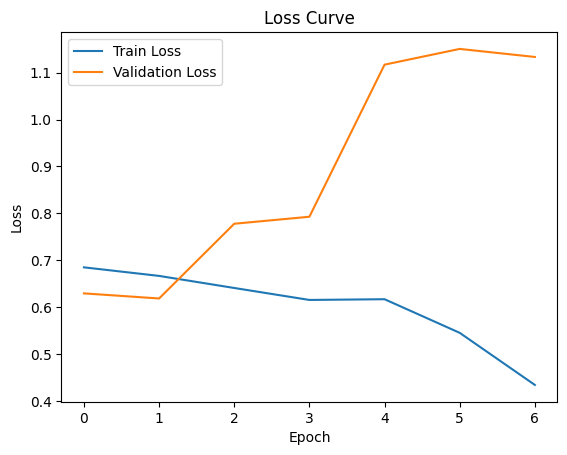

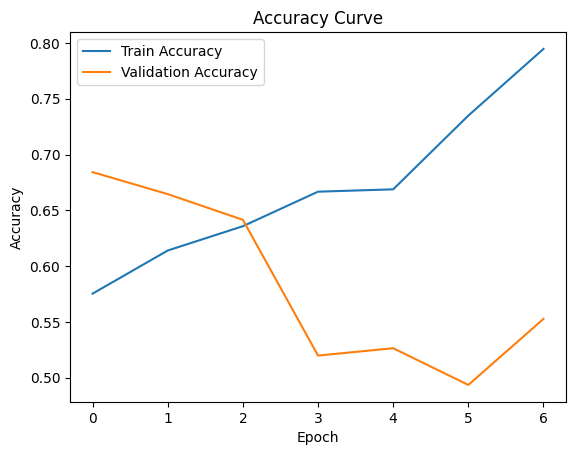

Test Accuracy: 0.6046, F1 Score: 0.3388, AUC: 0.7659


In [1]:
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from timm import create_model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from PIL import Image, ImageOps
import os

# -------------------------------
# 1. Load and Prepare Data
# -------------------------------
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Normalize class labels
class_counts = {'oa': 0, 'gout': 0, 'normal': 0, 'uncertain': 0, 'ra': 0}
for key, entry in data.items():
    if isinstance(entry, dict):
        class_label = entry.get('class', '').lower()
        if class_label in class_counts:
            class_counts[class_label] += 1
        else:
            print(f"Unexpected class label '{class_label}' found in entry with key {key}")

print("Class Distribution before balancing:", class_counts)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------------
# 2. Dataset and Data Augmentation
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Horizontal flip augmentation
def horizontal_flip(image):
    return ImageOps.mirror(image)

class FootDataset(Dataset):
    def __init__(self, data, classes, transform, augment=False):
        self.images = []
        self.patches = []
        self.labels = []
        self.transform = transform
        self.augment = augment
        
        for entry in data:
            if entry['class'].lower() in classes:
                label = 1 if entry['class'].lower() == classes[0] else 0
                
                # Raw image
                file_path = entry['file_path']
                if os.path.exists(file_path):
                    self.images.append(file_path)
                    self.labels.append(label)
                
                # Patches (up to 34)
                bbx_list = entry.get('bbx', [])
                if len(bbx_list) >= 34:
                    selected_patches = bbx_list[:34]
                    self.patches.append(selected_patches)
                else:
                    print(f"Insufficient patches for {file_path}")

        self.original_len = len(self.images)

    def __len__(self):
        return len(self.images) * 2 if self.augment else len(self.images)

    def __getitem__(self, idx):
        augment_image = self.augment and idx >= self.original_len
        actual_idx = idx % self.original_len

        # Load raw image
        image_path = self.images[actual_idx]
        label = self.labels[actual_idx]
        image = Image.open(image_path).convert('RGB')
        if augment_image:
            image = horizontal_flip(image)
        image = self.transform(image)

        # Load patches
        patch_list = self.patches[actual_idx]
        patch_images = [self.transform(Image.fromarray(patch)) for patch in patch_list]
        patches_tensor = torch.stack(patch_images)  # Shape: (34, 3, 224, 224)

        return image, patches_tensor, label

# Prepare balanced binary data
def prepare_balanced_data(data, target_class, normal_class='normal'):
    target_entries = [entry for entry in data.values() if entry['class'].lower() == target_class]
    normal_entries = [entry for entry in data.values() if entry['class'].lower() == normal_class]
    
    min_count = min(len(target_entries), len(normal_entries))
    target_entries = random.sample(target_entries, min_count)
    normal_entries = random.sample(normal_entries, min_count)

    print(f"Balanced Data: {target_class.upper()}: {len(target_entries)}, {normal_class.upper()}: {len(normal_entries)}")
    return target_entries + normal_entries

selected_classes = ('oa', 'normal')
balanced_data = prepare_balanced_data(data, selected_classes[0])

# Dataset with augmentation
dataset = FootDataset(balanced_data, selected_classes, transform, augment=True)
print(f"Total images after augmentation: {len(dataset)}")

# -------------------------------
# 3. Split Data (70% Train, 15% Val, 15% Test)
# -------------------------------
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# -------------------------------
# 4. Early Stopping Implementation
# -------------------------------
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# -------------------------------
# 5. Dual-Input Model Definition
# -------------------------------
class DualInputModel(nn.Module):
    def __init__(self, pretrained=True):
        super(DualInputModel, self).__init__()

        # Raw Image Branch - ResNet50
        resnet = models.resnet50(pretrained=pretrained)
        self.raw_branch = nn.Sequential(*list(resnet.children())[:-1])
        self.raw_feature_dim = resnet.fc.in_features

        # Patches Branch - Shared ResNet50
        self.patch_branch = nn.Sequential(*list(resnet.children())[:-1])
        self.patch_feature_dim = resnet.fc.in_features

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.raw_feature_dim + self.patch_feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, image, patches):
        # Raw Image Features
        raw_features = self.raw_branch(image)
        raw_features = raw_features.view(raw_features.size(0), -1)

        # Patches Features
        B, num_patches, C, H, W = patches.shape
        patches = patches.view(-1, C, H, W)
        patch_features = self.patch_branch(patches)
        patch_features = patch_features.view(B, num_patches, -1)
        patch_features = patch_features.mean(dim=1)  # Average pooling

        # Combine Features
        combined = torch.cat((raw_features, patch_features), dim=1)
        output = self.classifier(combined)
        return output

# Initialize Model
model = DualInputModel(pretrained=True).to(device)

# -------------------------------
# 6. Loss Function, Optimizer, Scheduler
# -------------------------------
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# -------------------------------
# 7. Training Loop with Early Stopping
# -------------------------------
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_preds, total_preds = 0.0, 0, 0

    for images, patches, labels in train_loader:
        images, patches, labels = images.to(device), patches.to(device), labels.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images, patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (outputs > 0.5).float()
        running_loss += loss.item() * images.size(0)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    scheduler.step()
    epoch_loss = running_loss / total_preds
    epoch_acc = correct_preds / total_preds
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss, val_correct_preds, val_total_preds = 0.0, 0, 0

    with torch.no_grad():
        for images, patches, labels in val_loader:
            images, patches, labels = images.to(device), patches.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(images, patches)
            val_batch_loss = criterion(outputs, labels)

            preds = (outputs > 0.5).float()
            val_loss += val_batch_loss.item() * images.size(0)
            val_correct_preds += (preds == labels).sum().item()
            val_total_preds += labels.size(0)

    val_epoch_loss = val_loss / val_total_preds
    val_epoch_acc = val_correct_preds / val_total_preds
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Early Stopping
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# -------------------------------
# 8. Plotting Results
# -------------------------------
# Loss Curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Accuracy Curves
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# -------------------------------
# 9. Final Evaluation on Test Set
# -------------------------------
model.eval()
test_labels, test_preds, test_probs = [], [], []

with torch.no_grad():
    for images, patches, labels in test_loader:
        images, patches, labels = images.to(device), patches.to(device), labels.float().to(device).unsqueeze(1)
        outputs = model(images, patches)
        preds = (outputs > 0.5).float()

        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(outputs.detach().cpu().numpy())

test_accuracy = (np.array(test_preds) == np.array(test_labels)).mean()
test_f1 = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs)

print(f"Test Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}, AUC: {test_auc:.4f}")


In [ ]:
del model
del optimizer
#del tensor
torch.cuda.empty_cache()

import gc
gc.collect()
torch.cuda.empty_cache()



NameError: name 'model' is not defined

: 

ResNet50 + Swin Transformer

Class Distribution: {'oa': 508, 'gout': 242, 'normal': 693, 'uncertain': 549, 'ra': 90}
Using device: cuda


/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Train Loss: 0.1238, Train Acc: 0.5865, Val Loss: 0.1190, Val Acc: 0.5921
Epoch [2/20], Train Loss: 0.1081, Train Acc: 0.6709, Val Loss: 0.1113, Val Acc: 0.6513
Epoch [3/20], Train Loss: 0.1009, Train Acc: 0.6990, Val Loss: 0.1184, Val Acc: 0.6579
EarlyStopping counter: 1 out of 5
Epoch [4/20], Train Loss: 0.1010, Train Acc: 0.7004, Val Loss: 0.1151, Val Acc: 0.6316
EarlyStopping counter: 2 out of 5
Epoch [5/20], Train Loss: 0.0754, Train Acc: 0.7862, Val Loss: 0.1220, Val Acc: 0.6316
EarlyStopping counter: 3 out of 5
Epoch [6/20], Train Loss: 0.0527, Train Acc: 0.8326, Val Loss: 0.1224, Val Acc: 0.6316
EarlyStopping counter: 4 out of 5
Epoch [7/20], Train Loss: 0.0475, Train Acc: 0.8706, Val Loss: 0.1138, Val Acc: 0.6447
EarlyStopping counter: 5 out of 5
Early stopping triggered.


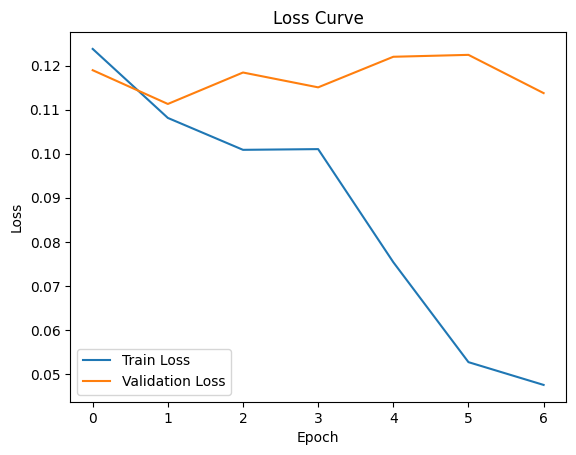

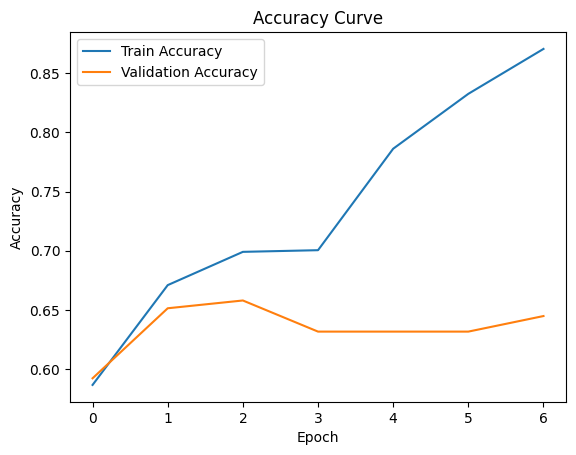

In [1]:
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms, models
from timm import create_model  # For Swin Transformer
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from PIL import Image
import os

# -------------------------------
# 1. Load and Prepare Data
# -------------------------------
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Normalize class labels
class_counts = {'oa': 0, 'gout': 0, 'normal': 0, 'uncertain': 0, 'ra': 0}
for key, entry in data.items():
    if isinstance(entry, dict):
        class_label = entry.get('class', '').lower()
        if class_label in class_counts:
            class_counts[class_label] += 1

print("Class Distribution:", class_counts)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------------
# 2. Dataset and DataLoader
# -------------------------------
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Modified Dataset to load raw images from 'bbx' or from 'file_path'
class FootDataset(Dataset):
    def __init__(self, data, classes, transform):
        self.data = []
        self.labels = []
        self.transform = transform
        for entry in data:
            if entry['class'].lower() in classes:
                label = 1 if entry['class'].lower() == classes[0] else 0
                if 'bbx' in entry and entry['bbx']:
                    self.data.append(entry['bbx'][0])  # Use raw image
                    self.labels.append(label)
                elif os.path.exists(entry['file_path']):
                    self.data.append(entry['file_path'])  # Use file path
                    self.labels.append(label)
                else:
                    print(f"File not found: {entry['file_path']} and no raw image provided.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_data = self.data[idx]
        label = self.labels[idx]
        if isinstance(image_data, str):
            image = Image.open(image_data).convert('RGB')
        else:
            image = Image.fromarray(image_data)
        image = self.transform(image)
        return image, label

# Prepare binary data
def prepare_binary_data(data, target_class, normal_class='normal'):
    target_entries = [entry for entry in data.values() if entry['class'].lower() == target_class]
    normal_entries = random.sample([entry for entry in data.values() if entry['class'].lower() == normal_class], len(target_entries))
    combined_data = target_entries + normal_entries
    random.shuffle(combined_data)
    return combined_data

selected_classes = ('oa', 'normal')
binary_data = prepare_binary_data(data, selected_classes[0])

# Dataset and Split
dataset = FootDataset(binary_data, selected_classes, transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Balanced Sampling
class_sample_count = [len([label for label in train_dataset.dataset.labels if label == t]) for t in [0, 1]]
weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
samples_weights = [weights[label] for label in [train_dataset.dataset.labels[i] for i in train_dataset.indices]]
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# -------------------------------
# 3. Two-Branch Model Definition
# -------------------------------
class TwoBranchModel(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchModel, self).__init__()

        # Global Branch: Swin Transformer
        self.global_branch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.global_branch.head = nn.Identity()
        self.global_feature_dim = self.global_branch.num_features

        # Local Branch: ResNet50
        resnet = models.resnet50(pretrained=pretrained)
        self.local_branch = nn.Sequential(*list(resnet.children())[:-1])
        self.local_feature_dim = resnet.fc.in_features

        # Classifier with placeholder input size (will adjust dynamically)
        self.classifier = nn.Sequential(
            nn.Linear(self.global_feature_dim + self.local_feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Global Branch
        global_features = self.global_branch.forward_features(x)
        if global_features.dim() == 4:
            global_features = global_features.mean(dim=[2, 3])
        elif global_features.dim() == 3:
            global_features = global_features.mean(dim=1)
        #print(f"Global Features Shape: {global_features.shape}")

        # Local Branch
        local_features = self.local_branch(x)
        local_features = local_features.view(local_features.size(0), -1)
        #print(f"Local Features Shape: {local_features.shape}")

        # Concatenate Features
        combined_features = torch.cat((global_features, local_features), dim=1)
        #print(f"Combined Features Shape: {combined_features.shape}")

        # Dynamically Adjust Classifier Input Layer if Needed
        if combined_features.shape[1] != self.classifier[0].in_features:
            self.classifier[0] = nn.Linear(combined_features.shape[1], 512).to(x.device)
            #print(f"Adjusted Linear Layer Input Dimension to {combined_features.shape[1]}")

        output = self.classifier(combined_features)
        return output


model = TwoBranchModel(pretrained=True).to(device)

# -------------------------------
# 4. Loss Function
# -------------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCELoss()

    def forward(self, inputs, targets):
        BCE_loss = self.bce_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

criterion = FocalLoss(alpha=0.75, gamma=2)

# -------------------------------
# 5. Optimizer and Scheduler
# -------------------------------
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5, verbose=True)

# -------------------------------
# 6. Training Loop with Accuracy
# -------------------------------
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        # Calculate accuracy
        preds = (outputs > 0.5).float()
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

    scheduler.step()
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * images.size(0)

            # Calculate validation accuracy
            preds = (outputs > 0.5).float()
            val_correct_preds += (preds == labels).sum().item()
            val_total_samples += labels.size(0)

    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_correct_preds / val_total_samples
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    # Print Epoch Results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Early Stopping
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# -------------------------------
# 7. Plotting Results
# -------------------------------
# Loss Curves
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Accuracy Curves
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()


Original Class Distribution:
OA: 508 images
NORMAL: 693 images
Selected 508 images for class OA
Selected 508 images for class NORMAL

After Augmentation:
OA: 1016 images
NORMAL: 1016 images


/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avaghasiya/.conda/envs/rsna/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Train Loss: 0.1233, Train Acc: 0.5584, Val Loss: 0.1096, Val Acc: 0.6414
Epoch [2/20], Train Loss: 0.0820, Train Acc: 0.7412, Val Loss: 0.2297, Val Acc: 0.5658
EarlyStopping counter: 1 out of 5
Epoch [3/20], Train Loss: 0.0330, Train Acc: 0.8481, Val Loss: 0.0478, Val Acc: 0.7961
Epoch [4/20], Train Loss: 0.0153, Train Acc: 0.8973, Val Loss: 0.0215, Val Acc: 0.8750
Epoch [5/20], Train Loss: 0.0039, Train Acc: 0.9564, Val Loss: 0.0156, Val Acc: 0.8947
Epoch [6/20], Train Loss: 0.0018, Train Acc: 0.9747, Val Loss: 0.0123, Val Acc: 0.8914
Epoch [7/20], Train Loss: 0.0008, Train Acc: 0.9930, Val Loss: 0.0111, Val Acc: 0.9046
Epoch [8/20], Train Loss: 0.0006, Train Acc: 0.9887, Val Loss: 0.0119, Val Acc: 0.9112
EarlyStopping counter: 1 out of 5
Epoch [9/20], Train Loss: 0.0005, Train Acc: 0.9930, Val Loss: 0.0102, Val Acc: 0.9145
Epoch [10/20], Train Loss: 0.0003, Train Acc: 0.9958, Val Loss: 0.0103, Val Acc: 0.9178
EarlyStopping counter: 1 out of 5
Epoch [11/20], Train Loss: 

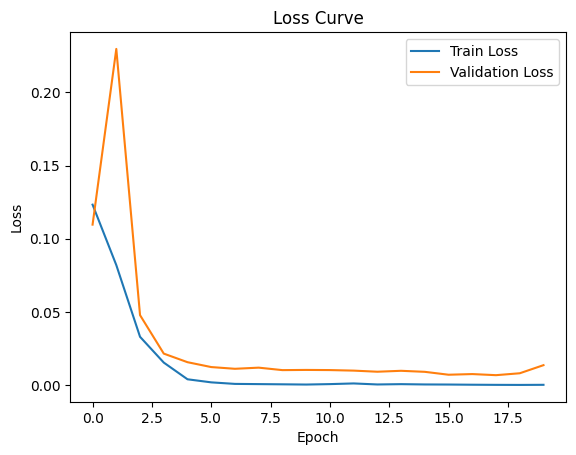

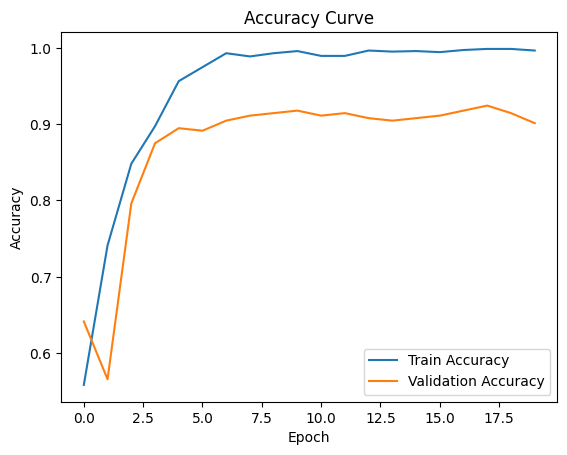

Test Accuracy: 0.9216, F1 Score: 0.9264, AUC: 0.9212


In [1]:
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms, models
from timm import create_model  # For Swin Transformer
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
from PIL import Image
import os

# -------------------------------
# 1. Load and Prepare Data
# -------------------------------
with open('updated_merge_json_200x300.pkl', 'rb') as f:
    data = pickle.load(f)

# Normalize class labels and count images
class_counts = {'oa': 0, 'normal': 0}
data_by_class = {'oa': [], 'normal': []}

for key, entry in data.items():
    class_label = entry.get('class', '').lower()
    if class_label in class_counts and os.path.exists(entry['file_path']):
        class_counts[class_label] += 1
        data_by_class[class_label].append(entry)

# Print original class distribution
print("Original Class Distribution:")
for cls, count in class_counts.items():
    print(f"{cls.upper()}: {count} images")

# -------------------------------
# 2. Balance Dataset
# -------------------------------
# Find the minimum class count to balance
min_class_count = min(class_counts.values())

# Randomly sample equal images from each class
balanced_data = []
for cls in class_counts.keys():
    sampled_data = random.sample(data_by_class[cls], min_class_count)
    balanced_data.extend(sampled_data)
    print(f"Selected {len(sampled_data)} images for class {cls.upper()}")

# -------------------------------
# 3. Dataset and DataLoader
# -------------------------------
# Image transformations with only Horizontal Flip
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Validation and Test transforms (No Augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset
class FootDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image = Image.open(entry['file_path']).convert('RGB')
        label = 1 if entry['class'].lower() == 'oa' else 0
        image = self.transform(image)
        return image, label

# Create dataset
full_dataset = FootDataset(balanced_data, transform=train_transform)

# Data Augmentation: Apply horizontal flip to duplicate images
augmented_data = balanced_data * 2  # Double the dataset with augmented copies
augmented_dataset = FootDataset(augmented_data, transform=train_transform)

# Print augmented data counts
augmented_class_counts = {'oa': 0, 'normal': 0}
for entry in augmented_data:
    augmented_class_counts[entry['class'].lower()] += 1

print("\nAfter Augmentation:")
for cls, count in augmented_class_counts.items():
    print(f"{cls.upper()}: {count} images")

# -------------------------------
# 4. Split Dataset
# -------------------------------
# Split augmented data into train (70%), val (15%), test (15%)
total_size = len(augmented_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    augmented_dataset, [train_size, val_size, test_size]
)

# Apply val/test transforms
val_dataset = Subset(FootDataset(augmented_data, transform=val_test_transform), val_dataset.indices)
test_dataset = Subset(FootDataset(augmented_data, transform=val_test_transform), test_dataset.indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -------------------------------
# 5. Two-Branch Model Definition
# -------------------------------
class TwoBranchModel(nn.Module):
    def __init__(self, pretrained=True):
        super(TwoBranchModel, self).__init__()

        # Global Branch: Swin Transformer
        self.global_branch = create_model('swin_tiny_patch4_window7_224', pretrained=pretrained)
        self.global_branch.head = nn.Identity()
        self.global_feature_dim = self.global_branch.num_features

        # Local Branch: ResNet50
        resnet = models.resnet50(pretrained=pretrained)
        self.local_branch = nn.Sequential(*list(resnet.children())[:-1])
        self.local_feature_dim = resnet.fc.in_features

        # Classifier with placeholder input size (will adjust dynamically)
        self.classifier = nn.Sequential(
            nn.Linear(self.global_feature_dim + self.local_feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Global Branch
        global_features = self.global_branch.forward_features(x)
        if global_features.dim() == 4:
            global_features = global_features.mean(dim=[2, 3])  # Mean Pooling over H and W
        elif global_features.dim() == 3:
            global_features = global_features.mean(dim=1)  # Pool over N

        # Debug: Print Global Features Shape
        #print(f"Global Features Shape: {global_features.shape}")

        # Local Branch
        local_features = self.local_branch(x)
        local_features = local_features.view(local_features.size(0), -1)

        # Debug: Print Local Features Shape
        #print(f"Local Features Shape: {local_features.shape}")

        # Concatenate Features
        combined_features = torch.cat((global_features, local_features), dim=1)

        # Debug: Print Combined Features Shape
        #print(f"Combined Features Shape: {combined_features.shape}")

        # Dynamically Adjust Classifier Input Layer if Needed
        if combined_features.shape[1] != self.classifier[0].in_features:
            self.classifier[0] = nn.Linear(combined_features.shape[1], 512).to(x.device)
            #print(f"Adjusted Linear Layer Input Dimension to {combined_features.shape[1]}")

        output = self.classifier(combined_features)
        return output


# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoBranchModel(pretrained=True).to(device)

# -------------------------------
# 6. Loss, Optimizer, Scheduler
# -------------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCELoss()

    def forward(self, inputs, targets):
        BCE_loss = self.bce_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss

criterion = FocalLoss(alpha=0.75, gamma=2)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5, verbose=True)

# -------------------------------
# 7. Training Loop
# -------------------------------
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct_preds, total_samples = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).float()
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

    scheduler.step()
    train_loss = running_loss / total_samples
    train_acc = correct_preds / total_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# -------------------------------
# 8. Plotting Loss & Accuracy
# -------------------------------
# Loss Curve
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Accuracy Curve
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# -------------------------------
# 9. Final Test Evaluation
# -------------------------------
model.eval()
test_correct, test_total = 0, 0
test_preds, test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
test_f1 = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_preds)

print(f"Test Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}, AUC: {test_auc:.4f}")
